# Group Project Report: 
# Evaluation of K-Nearest Neighbours Classification Prediction on Algerian Forest Fire based on Fine Fuel Moisture Code (FFMC) and Drought Code (DC)
Group members: Cassie Zhong, Khoi Nguyen, Helen He, Donna Li

## Introduction

### Background information: 
While forest fires can be incredibly destructive to the environment, they are also a natural part of forest life cycles. To mitigate risks and better prepare local areas, being able to predict if a forest fire will occur at a given time would be very beneficial. 

Researchers have collected data on forest fires in two regions of Algeria, Bejaia and Sidi Bel-Abbes, from June 2012 to September 2012 (https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++). This dataset includes 244 total observations and 10 variables: 
- Temperature, in Celsius degrees
- Relative humidity, in %
- Wind speed, in km/h
- Rain, in mm
- Fine Fuel Moisture Code (FFMC)
- Duff Moisture Code (DMC)
- Drought Code (DC)
- Initial Spread Index (ISI)
- Buildup Index (BUI)
- Fire Weather Index (FWI)

Six of these variables (FFMC, DMC, DC, ISI, BUI and FWI) are components of the Forest Fire Weather Index System (https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi), indicating relative potential for wildfires, and are calculated from the remaining four variables (temperature, relative humidity, wind speed and rain).

<img src='https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif' width='400'>

Source: https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif

Using this dataset, we will attempt to perform K-nearest neighbours classification to predict from a new set of measurements if a forest fire will occur, and we will evaluate the accuracy of such predictions.

### Question: 
How accurate is the prediction of whether a fire will occur based on FFMC and DC using knn Classification?

In [97]:
###
#   Run this cell to install GGally package
###

install.packages("GGally")

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [98]:
###
#   Load necessary packages
###

library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(tidyr)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(9999)

## Preliminary exploratory data analysis

In [99]:
###
#   Step 1: Reading the dataset into R
###
dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

# Read dataset of Bajaia region and change Classes column type to fct
bajaia_data_all <- read_csv(dataset_url, skip = 1, n_max = 122) %>%
    mutate(Classes = as.factor(Classes))

# Read first 43 rows of dataset of Sidi-Bel Abbes region and change Classes column type to fct
sidi_data_1 <- read_csv(dataset_url, skip = 126, n_max = 43) %>%
    mutate(Classes = as.factor(Classes))

# Read remaining rows of dataset of Sidi-Bel Abbes region and change Classes column type to fct
sidi_data_2_colnames <- colnames(sidi_data_1)
sidi_data_2 <- read_csv(dataset_url, skip = 171, col_names = sidi_data_2_colnames) %>%
    mutate(Classes = as.factor(Classes))

# Concatenate the Sidi-Bel Abbes data frames
sidi_data_all <- rbind(sidi_data_1, sidi_data_2)

# Display raw datasets
# bajaia_data_all %>%
#     head(6)
# sidi_data_all %>%
#     head(6)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),

In [100]:
###
#   Step 2: Dataset Cleaning & Wrangling
###

# Bind new Region column to each data frame
bajaia_region <- "Bajaia"
sidi_region <- "Sidi-Bel Abbes"
bajaia_data_all["Region"] <- bajaia_region
sidi_data_all["Region"] <- sidi_region


# Combine Bajaia and Sidi-Bel Abbes data frames
fire_data <- rbind(bajaia_data_all, sidi_data_all)

# Split data into training and testing sets
fire_split <- initial_split(fire_data, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

# Display datasets
# fire_data
# fire_train
# fire_test

In [101]:
###
#   Step 3: Summarize data from training dataset
###

# Get number of observations for each Classes in training dataset
fire_train_yes <- fire_train %>%
    filter(Classes == "fire") %>%
    nrow()
fire_train_no <- fire_train %>%
    filter(Classes == "not fire") %>%
    nrow()
observations_per_class <- tibble(classes = c("fire", "not fire"), 
                                 observations = c(fire_train_yes, fire_train_no))
observations_per_class

classes,observations
<chr>,<int>
fire,103
not fire,80


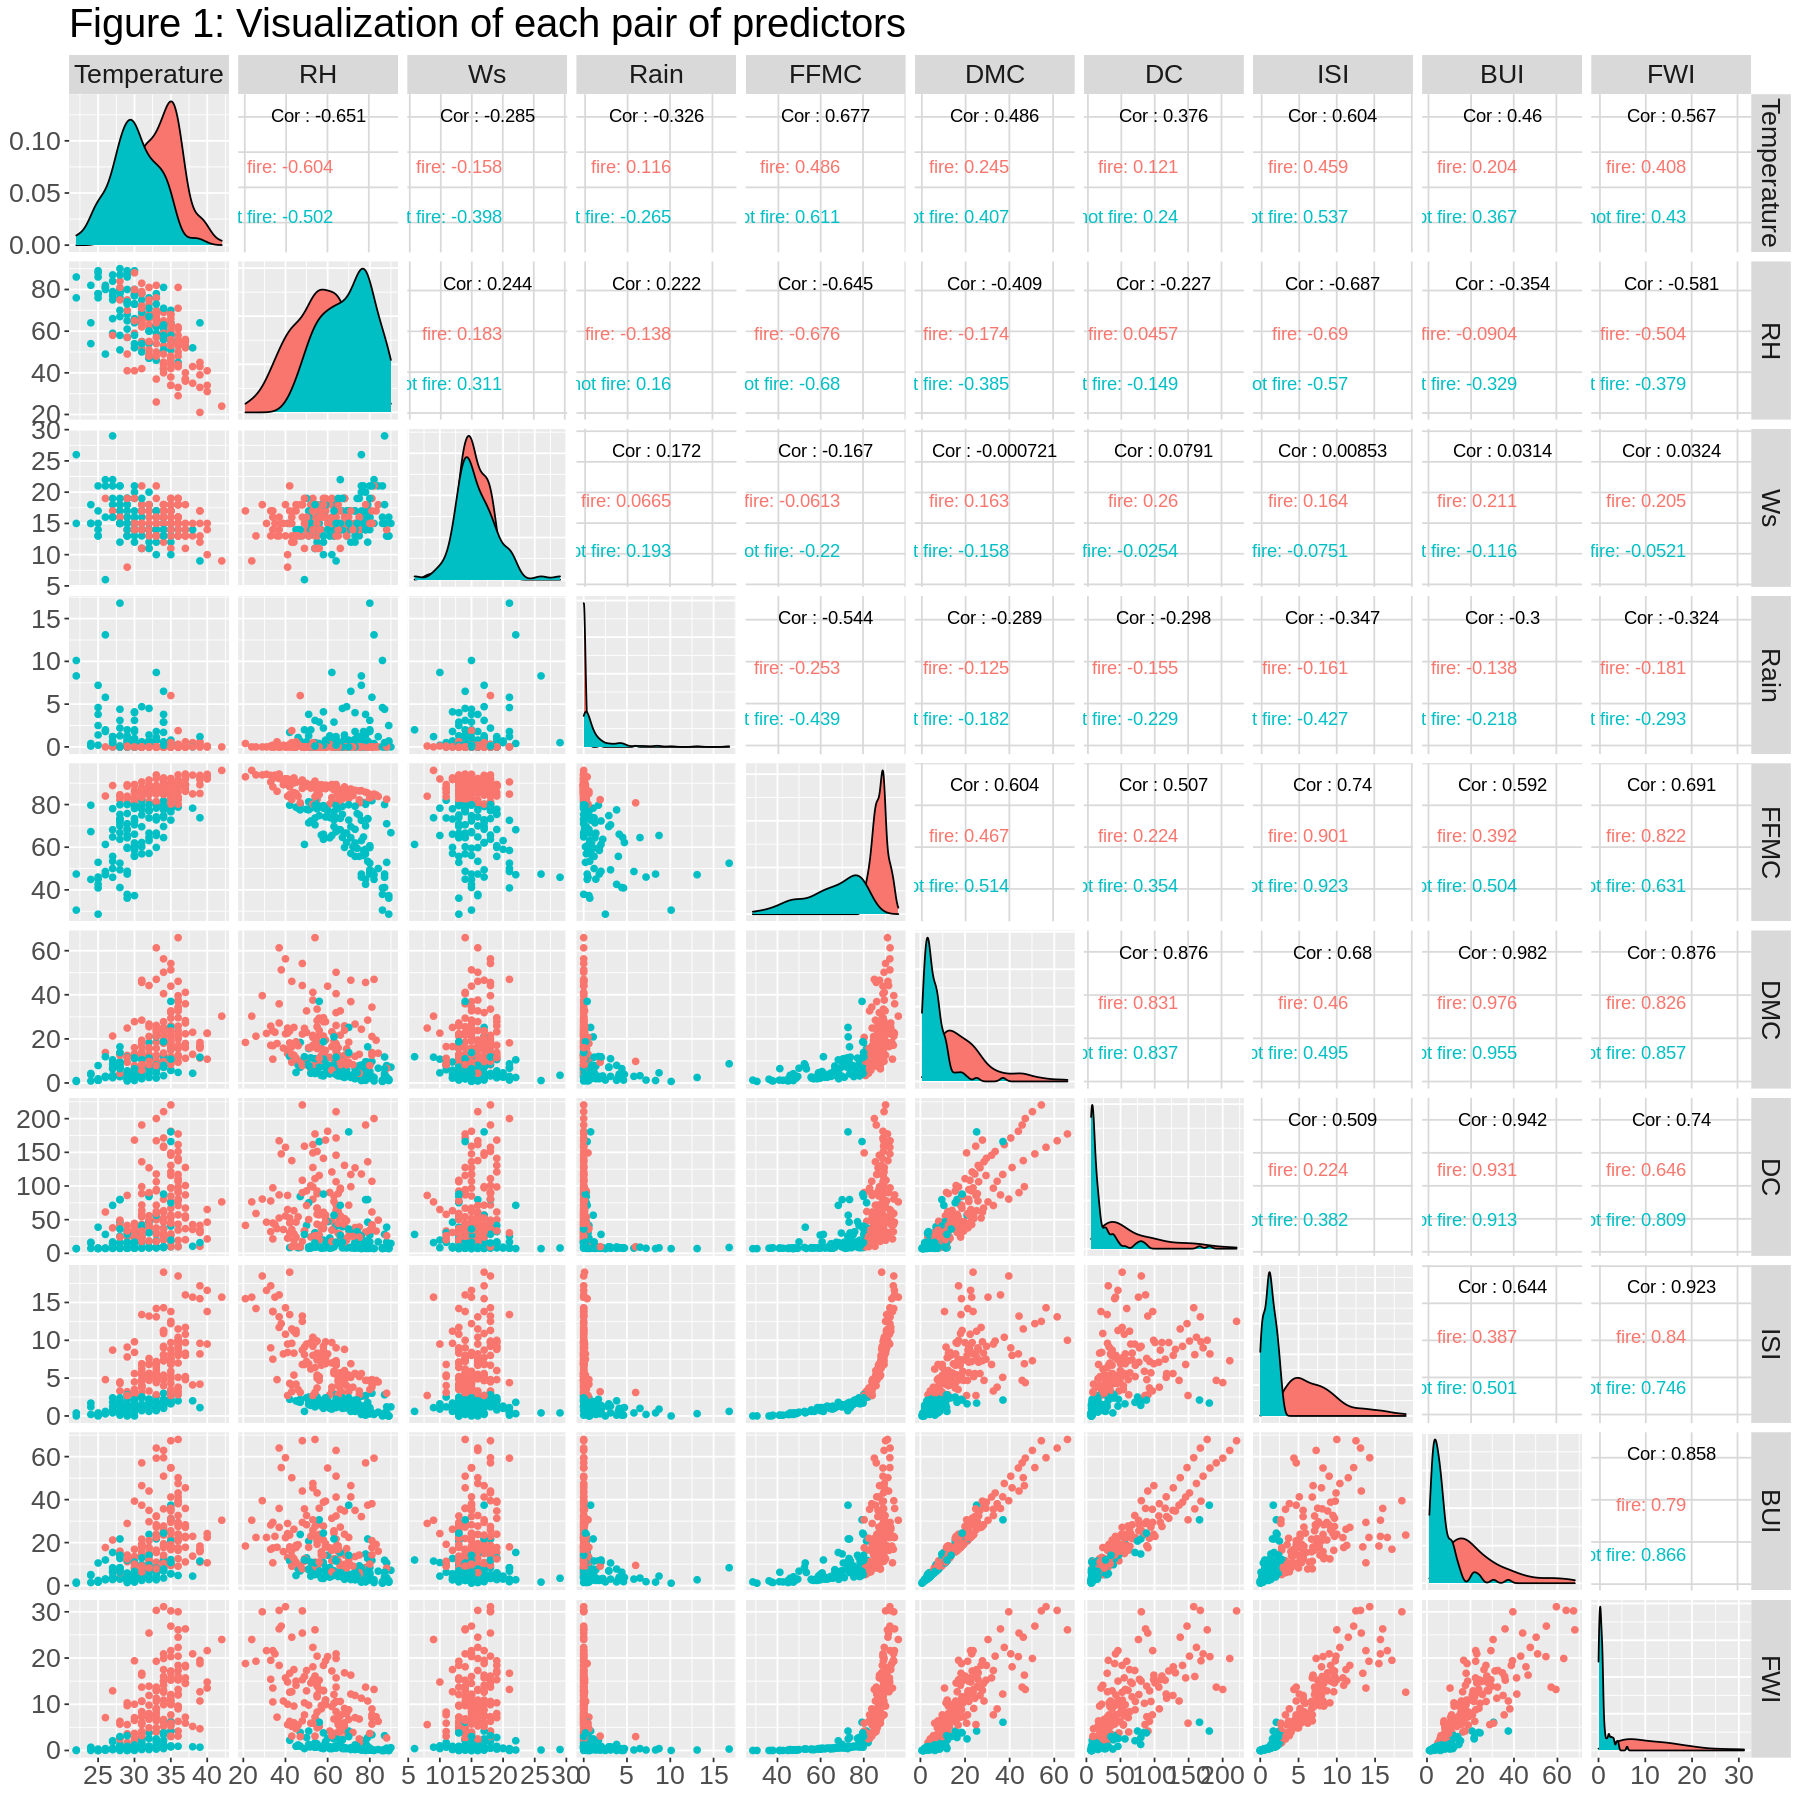

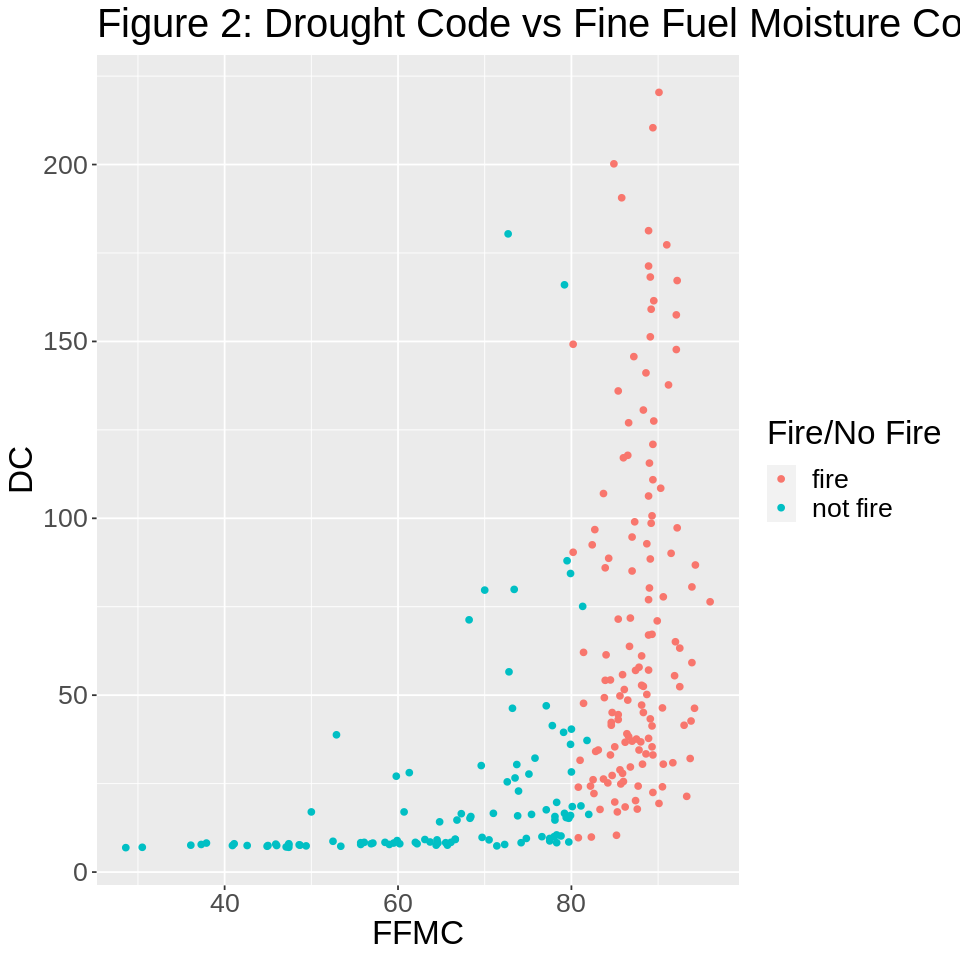

In [102]:
###
#   Step 4: Visualize data from training dataset
###

# Plot each variables against each other
options(repr.plot.height = 15, repr.plot.width = 15)
variables_all_plot <- ggpairs(fire_data, columns = 4:13, aes(color = Classes)) + 
                    ggtitle("Figure 1: Visualization of each pair of predictors") +
                    theme(text = element_text(size = 20))
variables_all_plot

# Create a scatterplot of FFMC vs DC
options(repr.plot.height = 8, repr.plot.width = 8)
ffmc_dc_plot <- ggplot (fire_data, aes(x = FFMC, y = DC, color = Classes)) +
                    geom_point() +
                    labs(x = "FFMC", y = "DC", color = "Fire/No Fire") +
                    ggtitle("Figure 2: Drought Code vs Fine Fuel Moisture Code") +
                    theme(text = element_text(size = 20))
ffmc_dc_plot

## Data Analysis

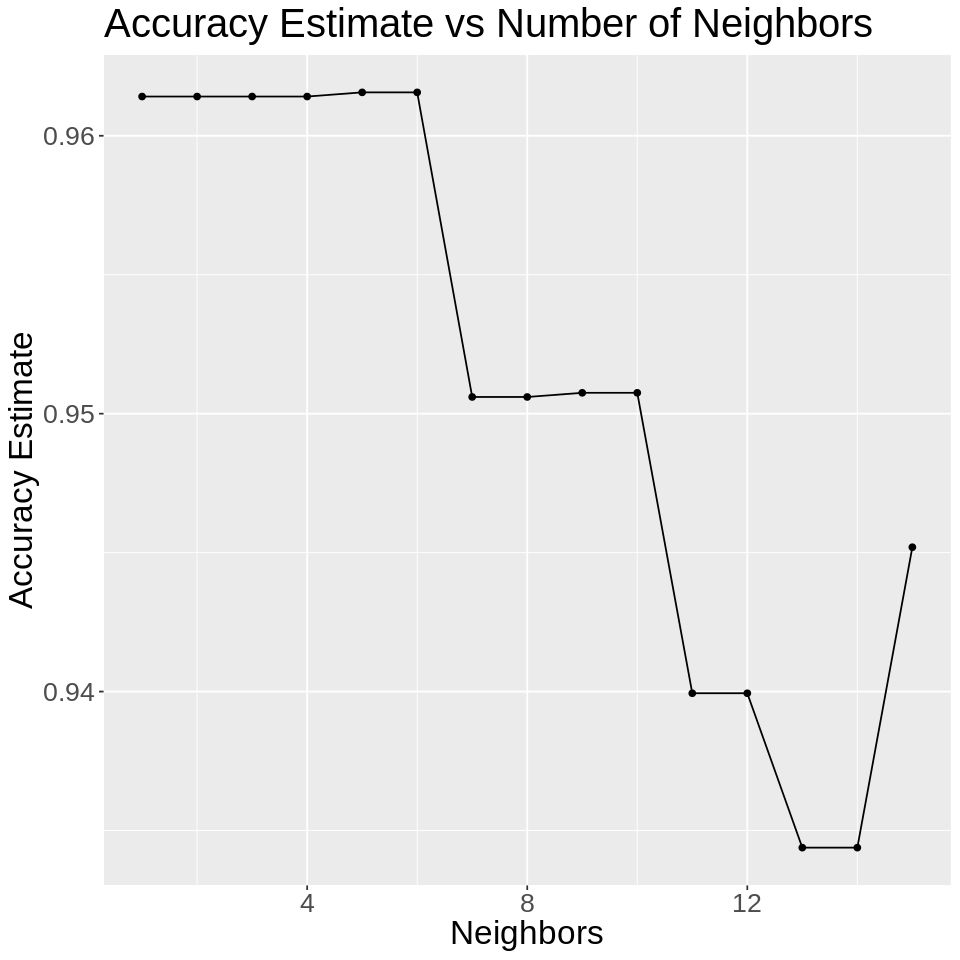

In [103]:
###
#   Cross-validation for K-NN model tuning
###

# Create recipe for data pre-processing from training dataset
fire_recipe <- recipe(Classes ~ FFMC + DC, data = fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

# Create 5 fold splits of training data
fire_vfold <- vfold_cv(fire_train, v = 5, strata = Classes)

# Define K-NN model specification for K tuning
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Perform cross-validation with 15 values of K
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
knn_results_tune <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = fire_vfold, grid = k_vals) %>%
    collect_metrics()
# knn_results_tune

# Plot accuracy vs K 
accuracy_vs_k <- knn_results_tune %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Accuracy Estimate vs Number of Neighbors") +
        theme(text = element_text(size = 20))
accuracy_vs_k

From this plot, we choose $k = 5$.

In [104]:
###
#   Train K-NN model with K = 5
###

# Re-define K-NN model specification with  K = 5
tuned_k = 5
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tuned_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Train model with training set
fire_knn_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    fit(fire_train)
fire_knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~tuned_k,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04371585
Best kernel: rectangular
Best k: 5

In [105]:
###
#   Evaluate accuracy of model
###

# Standardize testing set with standardization steps from training set
# scaled_fire_test <- bake(fire_recipe, fire_test)

# Predict labels in testing set
fire_test_predictions <- predict(fire_knn_fit, fire_test) %>%
    bind_cols(fire_test)

# Report accuracy and confusion matrix of predictions
fire_metrics <- fire_test_predictions %>%
    metrics(truth = Classes, estimate = .pred_class)
fire_conf_mat <- fire_test_predictions %>%
    conf_mat(truth = Classes, estimate = .pred_class)

In [106]:
fire_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9666667
kap,binary,0.9321267


In [107]:
fire_conf_mat

          Truth
Prediction fire not fire
  fire       33        1
  not fire    1       25